# IE 360 Homework 3
# Burak Nur Erdem
# Forecasting The Number of Newly Established Firms in December 2020 using a Regression Model


## Table of Contents

1. Introduction
2. The Manipulation, Preperation and Assessment of the Data
3. Building a Suitable Model
4. Testing the Model
5. Forecasting December 2020
6. Conclusion


# 1. Introduction

In this homework, I have built a regression model of the number of newly established firms and then forecasted the next month's value. 

I chose some macroeconomic factors as independent variables of the model as I thought they play determining roles for the number of newly established firms. These factors are:
<br>
- Industrial Production Index
- Exchange Rate
- Commercial Interest Rate For Loans
- Real Sector Confidence Index
- Positive Survey Answers of a Question of "How do you expect your production to develop over the next 3 months?"
- Unemployment Rate
- GDP

<br>
I expect to see positive relationships with the confidence index, production index, GDP, Survey Results and a negative relationship with the interest rate. I am not sure about the relationship with the exchange rate and the unemployment rate. My assumptions are that more firms are founded when exchange rate is high, because the investors from abroad are motivated and when the unemployment rate is high, because the unemployed may found establishments or excess of free labor motivates founders.
<br><br>
I took the data from the Turkish Central Bank website according to these expectations. I also assumed there would be a monthly seasonality and a trend in the number of newly established firms.

# 2. The Manipulation, Preperation and Assessment of the Data

Firstly, the data is read from an .xlsx file. Unnecessary rows are deleted, the month and trend factors are added to data table.
<br><br>
There is a problem of missing values. We don't have the values of the GDP and the unemployment rate for October, November, December 2020 and the production index for November and December 2020. This is not a problem for building a regression model, however if I am to be able use these factor as independent variables in forecasting, I have to have the values at least for the December 2020 or discard these factors and don't include them in the model. I have chosen to include them into the model and fill the missing values with a naive approach. I said that the missing values would be similar to last observed values and used them to fill the missing values. This is an huge assumption, however, I think that discarding the factors would leave the model worse off. Also as I explained below, I ended up not using the GDP in the model which was the factor that I was most unsure of naively forecasting the last quarter. I believe the umeployment rate and the production index would not vary too much in these months.
<br><br>
Also, the GDP is quarterly announced, so I manipulated its period so that it would be monthly and the same months that are in the same quarter would have the same values of that quarter.

Date,ProdIndex,ExRate,InterestRate,ConfIndex,Survey,NewlyEstablished,UnempRate,Month,Trend
2020-07-01,119.5729,6.851095,10.3040,99.4,42.9,10394,13.4,7,127
2020-08-01,115.1583,7.252190,12.8500,105.2,41.1,9496,13.2,8,128
2020-09-01,133.1434,7.507782,14.2850,105.7,33.4,10764,12.7,9,129
2020-10-01,134.7123,7.873881,15.2320,109.7,31.6,10419,12.7,10,130
2020-11-01,134.7123,8.003324,17.1875,107.4,25.3,8782,12.7,11,131
2020-12-01,134.7123,7.721065,18.9700,110.4,24.5,NA,12.7,12,132


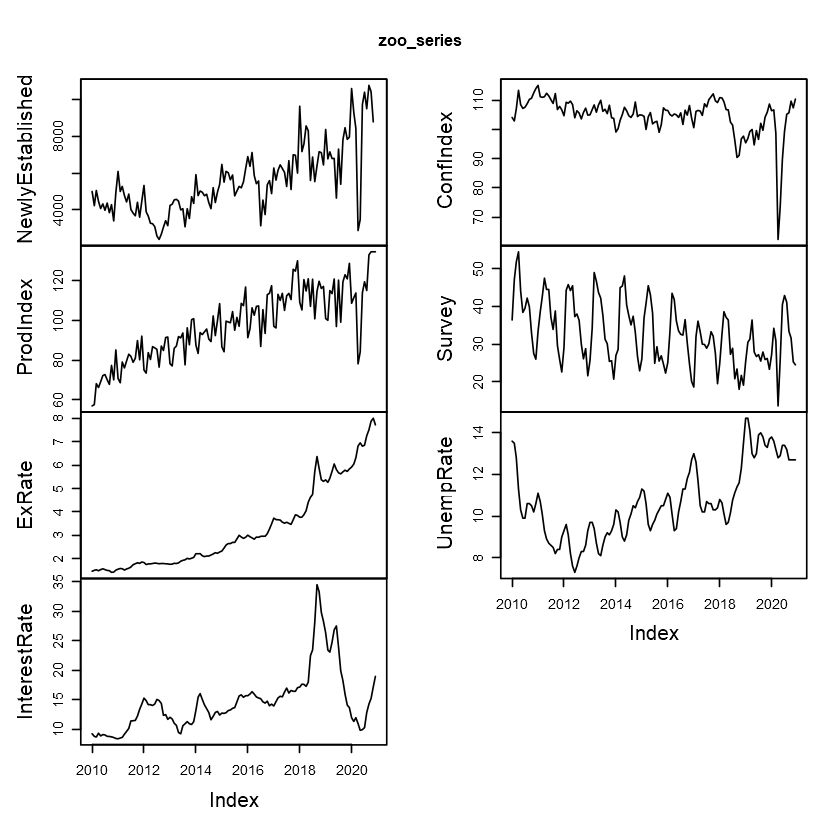

In [1]:
suppressWarnings(suppressMessages(library(ggplot2)))
suppressWarnings(suppressMessages(library(lubridate)))
suppressWarnings(suppressMessages(library(data.table)))
suppressWarnings(suppressMessages(library(readxl)))
suppressWarnings(suppressMessages(library(zoo)))
suppressWarnings(suppressMessages(library("forecast")))

dtEstablished = data.table(read_excel("IE 360 Hw3 Data.xlsx"))

colnames(dtEstablished) = c("Date", "ProdIndex", "ExRate", "InterestRate", "ConfIndex", "Survey",
                            "NewlyEstablished", "UnempRate")


dtEstablished = dtEstablished[1:132]


# Correcting the types of variables
dtEstablished[,Date:=ym(dtEstablished[,Date])]
dtEstablished[,ProdIndex:=as.numeric(ProdIndex)]
dtEstablished[,ExRate:=as.numeric(ExRate)]
dtEstablished[,InterestRate:=as.numeric(InterestRate)]

# Addition of Month factor and Trend
dtEstablished[,Month:=as.factor(month(Date))]
dtEstablished[,Trend:=1:.N]

# Naively filling missing values (huge assumption)
dtEstablished[Date >= "2020-10-01", UnempRate:=dtEstablished[129, UnempRate]]
dtEstablished[Date == "2020-11-01", ProdIndex:=dtEstablished[Date == "2020-10-01",ProdIndex]] 
dtEstablished[Date == "2020-12-01", UnempRate:=dtEstablished[Date == "2020-11-01",UnempRate]]
dtEstablished[Date == "2020-12-01", ProdIndex:=dtEstablished[Date == "2020-11-01",ProdIndex]]

tail(dtEstablished)


# Plotting the variation of factors and the objective variable over time
zoo_series=zoo(dtEstablished[,list(NewlyEstablished,ProdIndex,ExRate,InterestRate,ConfIndex,Survey,UnempRate)],
               dtEstablished$Date)
plot(zoo_series)

Date,Gdp
2020-07-01,1419482738.0436
2020-08-01,1419482738.0436
2020-09-01,1419482738.0436
2020-10-01,NA
2020-11-01,NA
2020-12-01,NA


Date,Gdp
2020-07-01,1419482738.0436
2020-08-01,1419482738.0436
2020-09-01,1419482738.0436
2020-10-01,1419482738.0436
2020-11-01,1419482738.0436
2020-12-01,1419482738.0436


Classes 'data.table' and 'data.frame':	132 obs. of  11 variables:
 $ Date            : Date, format: "2010-01-01" "2010-02-01" ...
 $ ProdIndex       : num  56.8 57.5 68.1 66.1 69.1 ...
 $ ExRate          : num  1.47 1.51 1.53 1.49 1.53 ...
 $ InterestRate    : num  9.26 8.83 8.7 9.36 8.9 ...
 $ ConfIndex       : num  104 103 107 113 108 ...
 $ Survey          : num  36.4 47.1 51.8 54.5 44.1 38.4 39.5 42.2 39.9 33 ...
 $ NewlyEstablished: num  5000 4230 5055 4466 4072 ...
 $ UnempRate       : num  13.6 13.5 12.8 11.3 10.3 9.9 9.9 10.6 10.6 10.5 ...
 $ Month           : Factor w/ 12 levels "1","2","3","4",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ Trend           : int  1 2 3 4 5 6 7 8 9 10 ...
 $ Gdp             : num  2.42e+08 2.42e+08 2.42e+08 2.81e+08 2.81e+08 ...
 - attr(*, ".internal.selfref")=<externalptr> 


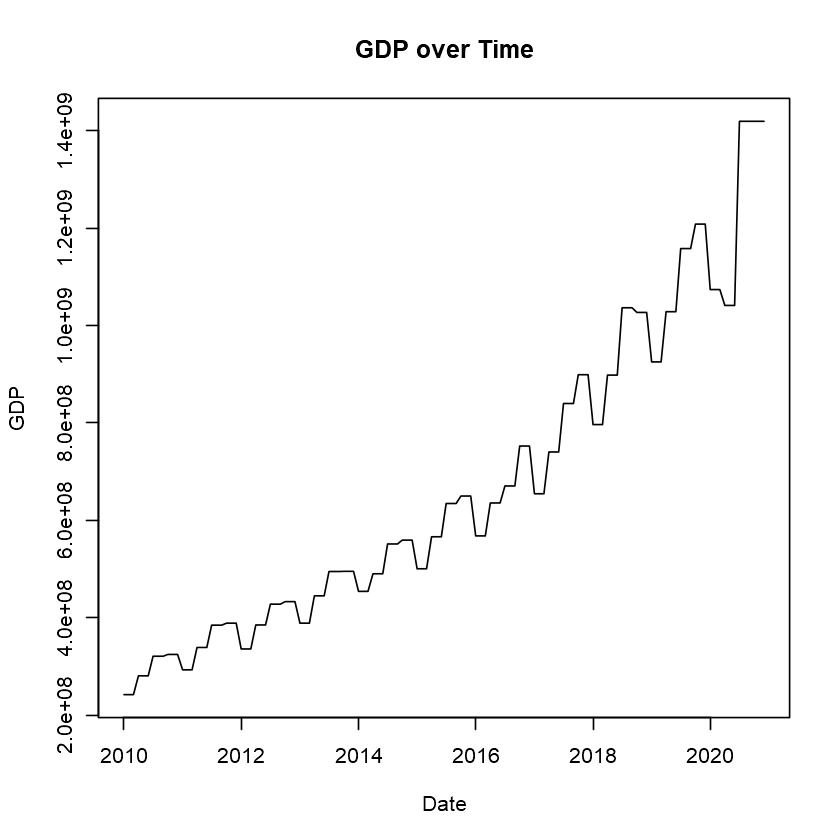

In [2]:
# Reading GDP and manipulating it in a useful way
gdpQuarterly = suppressMessages(data.table(read_excel("IE360 Hw3 GDP.xlsx")))
gdpQuarterly[, 3:= NULL]
colnames(gdpQuarterly) = c("Date", "Gdp")

gdpQuarterly = gdpQuarterly[1:44]

gdpQuarterly[, Date:=yq(Date)]
Date = seq.Date(as.Date("2010-01-01"),as.Date("2020-12-01"), by= "month")
gdpQuarterly[44,Date:=as.Date("2020-10-01")]
gdpMonthly = data.table(Date)

gdpMonthly[Date %in% gdpQuarterly$Date, Gdp:=gdpQuarterly$Gdp]
gdpMonthly[Date %in%(gdpQuarterly$Date + months(1)), Gdp:=gdpQuarterly$Gdp]
gdpMonthly[Date %in%(gdpQuarterly$Date + months(2)), Gdp:=gdpQuarterly$Gdp]

# We are missing the last quarterly GDP of 2020
# which is needed for forecasting in 2020 December
tail(gdpMonthly)

# Naively say that is would be same as in quarter 3
gdpMonthly[Date >= as.Date("2020-10-01"), Gdp:=gdpMonthly[Date == as.Date("2020-09-01"),Gdp]]
tail(gdpMonthly)

plot(y = gdpMonthly$Gdp, x = gdpMonthly$Date, type = "l", xlab = "Date", ylab = "GDP", main = "GDP over Time")


dtEstablished[, Gdp:=as.numeric(gdpMonthly$Gdp)]

str(dtEstablished)

Seperating the month we are trying to forecast from the data will ease the way of building models and forecasting.

In [3]:
# Seperation of to be forecasted month
goalMonth = dtEstablished[132]
dtEstablished = dtEstablished[1:131]

tail(dtEstablished)
goalMonth

Date,ProdIndex,ExRate,InterestRate,ConfIndex,Survey,NewlyEstablished,UnempRate,Month,Trend,Gdp
2020-06-01,114.0334,6.808832,9.9700,89.8,40.5,9719,13.4,6,126,1041339497
2020-07-01,119.5729,6.851095,10.3040,99.4,42.9,10394,13.4,7,127,1419482738
2020-08-01,115.1583,7.252190,12.8500,105.2,41.1,9496,13.2,8,128,1419482738
2020-09-01,133.1434,7.507782,14.2850,105.7,33.4,10764,12.7,9,129,1419482738
2020-10-01,134.7123,7.873881,15.2320,109.7,31.6,10419,12.7,10,130,1419482738
2020-11-01,134.7123,8.003324,17.1875,107.4,25.3,8782,12.7,11,131,1419482738


Date,ProdIndex,ExRate,InterestRate,ConfIndex,Survey,NewlyEstablished,UnempRate,Month,Trend,Gdp
2020-12-01,134.7123,7.721065,18.97,110.4,24.5,NA,12.7,12,132,1419482738


Below, I plotted the each factor versus the number of newly established firms. We expect to see a relation between the dependent and independent factors, but we don't see the relations in every factor I assumed to see. I think that the plots with interest rate, survey results and confidence index is strange. I expected to see positive relations with survey results and confidence index and negative relationship with the interest rate. The plots don't show such relations. What's more strange is that these factors became significant when I don't include the GDP in the model as I did below. So, I kept these factors.

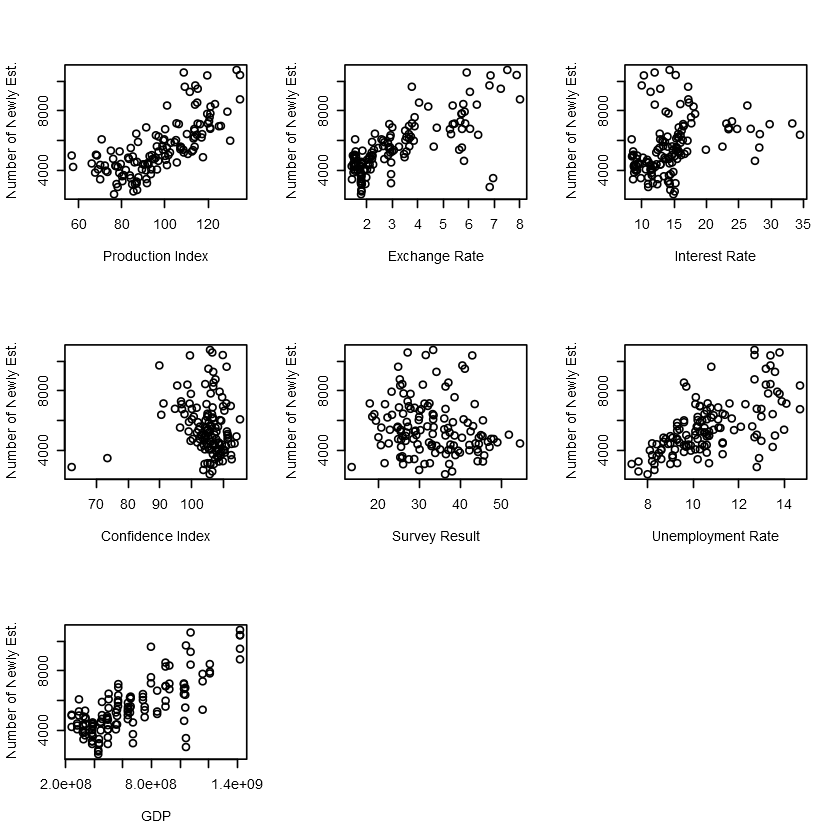

In [4]:
par(mfrow=c(3,3))
plot(x=dtEstablished$ProdIndex, y=dtEstablished$NewlyEstablished, type="p"
     , xlab = "Production Index", ylab = "Number of Newly Est.")
plot(x=dtEstablished$ExRate, y=dtEstablished$NewlyEstablished, type="p"
     , xlab = "Exchange Rate", ylab = "Number of Newly Est.")
plot(x=dtEstablished$InterestRate, y=dtEstablished$NewlyEstablished, type="p"
     , xlab = "Interest Rate", ylab = "Number of Newly Est.")
plot(x=dtEstablished$ConfIndex, y=dtEstablished$NewlyEstablished, type="p"
     , xlab = "Confidence Index", ylab = "Number of Newly Est.")
plot(x=dtEstablished$Survey, y=dtEstablished$NewlyEstablished, type="p"
     , xlab = "Survey Result", ylab = "Number of Newly Est.")
plot(x=dtEstablished$UnempRate, y=dtEstablished$NewlyEstablished, type="p"
     , xlab = "Unemployment Rate", ylab = "Number of Newly Est.")
plot(x=dtEstablished$Gdp, y=dtEstablished$NewlyEstablished, type="p"
     , xlab = "GDP", ylab = "Number of Newly Est.")

# 3. Building a Suitable Model

Below, there is the first model with trend, month factor and chosen economic factors. Suprisingly, the GDP is came up unsignificant so I removed it and modeled again.


Call:
lm(formula = NewlyEstablished ~ Month + Trend + ProdIndex + ExRate + 
    InterestRate + ConfIndex + Survey + UnempRate + Gdp, data = dtEstablished)

Residuals:
     Min       1Q   Median       3Q      Max 
-1660.77  -389.80    55.84   353.72  1653.83 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -7.489e+03  1.685e+03  -4.446 2.09e-05 ***
Month2       -1.327e+03  3.059e+02  -4.338 3.18e-05 ***
Month3       -2.312e+03  3.698e+02  -6.253 7.72e-09 ***
Month4       -2.296e+03  3.771e+02  -6.087 1.68e-08 ***
Month5       -2.774e+03  3.644e+02  -7.611 9.61e-12 ***
Month6       -2.466e+03  3.378e+02  -7.301 4.59e-11 ***
Month7       -2.845e+03  3.616e+02  -7.867 2.60e-12 ***
Month8       -2.638e+03  3.357e+02  -7.858 2.72e-12 ***
Month9       -2.922e+03  3.278e+02  -8.913 1.12e-14 ***
Month10      -2.859e+03  3.363e+02  -8.501 9.77e-14 ***
Month11      -2.918e+03  3.342e+02  -8.733 2.90e-14 ***
Month12      -3.215e+03  3.782e+02  -8.502 9.70e-14 *

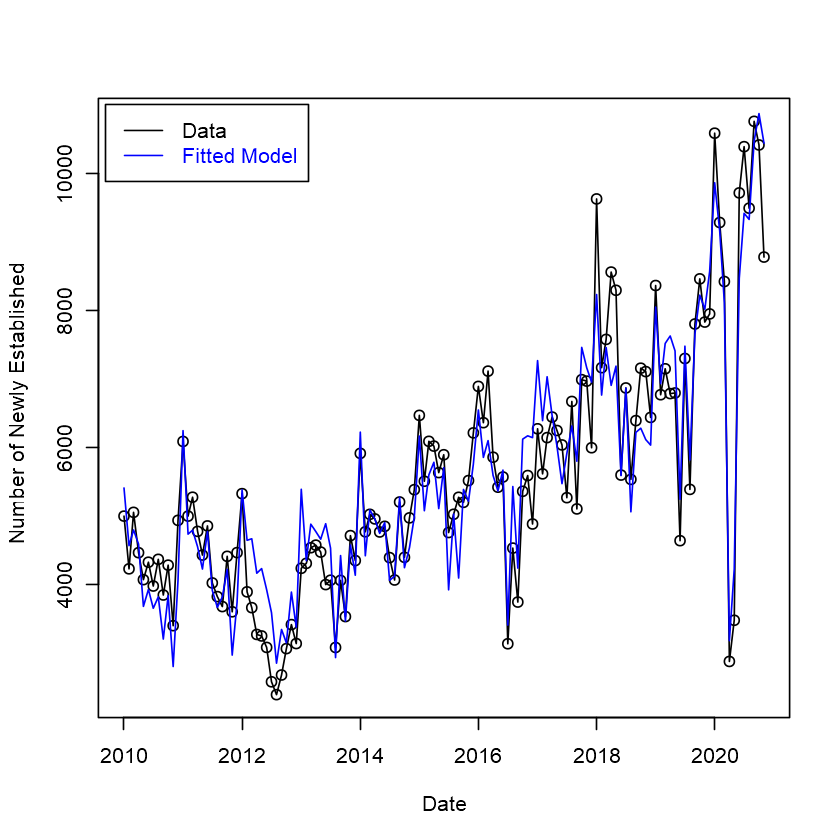


	Breusch-Godfrey test for serial correlation of order up to 23

data:  Residuals
LM test = 55.122, df = 23, p-value = 0.0001875


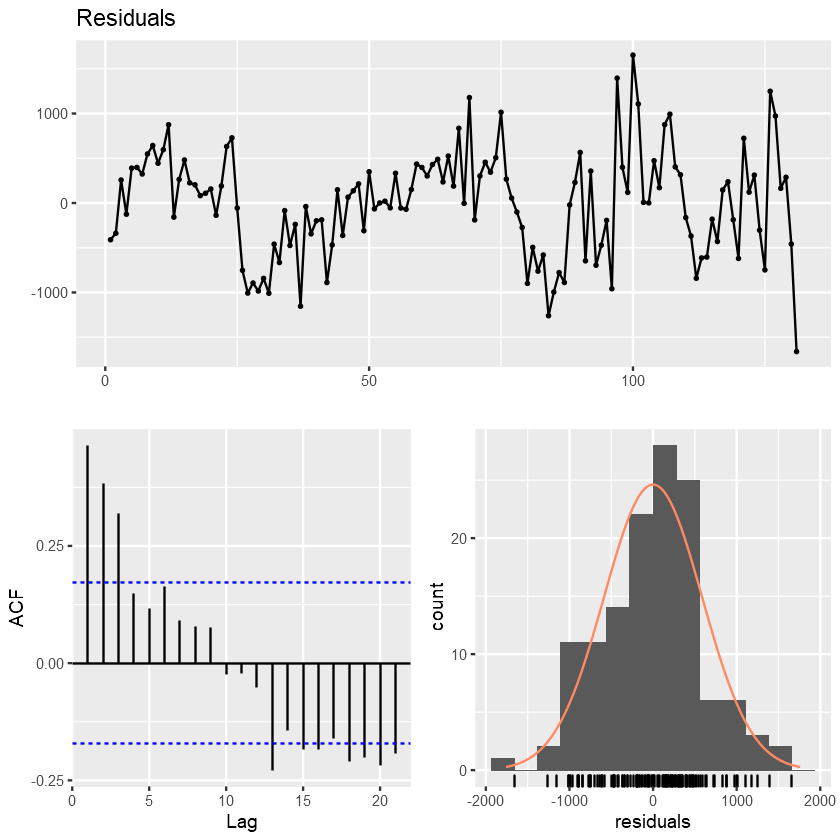

In [5]:
fitModel = lm(formula = NewlyEstablished~Month+Trend+ProdIndex+ExRate+InterestRate
              +ConfIndex+Survey+UnempRate+Gdp,data = dtEstablished)

summary(fitModel)

plot(x=dtEstablished$Date, y=dtEstablished[,NewlyEstablished], type = "o",
     xlab = "Date", ylab = "Number of Newly Established")
lines(x=dtEstablished$Date, y=fitModel$fitted, col = "blue")
legend("topleft", col = c("black", "blue"), text.col = c("black", "blue"), legend = c("Data", "Fitted Model"),
       inset = c(0.01, 0.01), lty = c(1,1))

checkresiduals(fitModel)

With the removal of the GDP, every factor came up significant. Even though, the confidence index has high p-value, I have chosen to keep it.
<br><br>
I have chosen to keep the intercept to have reliable R squared values and the model has a relatively high R squared value which means that the model is able to explain most of the variation in the data.
<br><br>
When we examine the residuals, we can see that there are some problems. It is hard to say that it is stationary. First, it goes above zero and then falls under zero and kind of repeats this pattern two more times and the variance seems to get higher towards the end. This means that we were unable to model some movement in the data, but I don't know what could be added or modified. Maybe a more extensive research on the economic situation over these years would help us answer such a movement in the residuals.
<br><br>
When we look at the autocorrelation of the lags in residuals, we see that the first lags seem correlated which could mean that the error is repeated in consecutive values. I am not sure how to solve this.
<br><br>
The histogram of the residuals seems normal enough.


Call:
lm(formula = NewlyEstablished ~ Month + Trend + ProdIndex + ExRate + 
    InterestRate + ConfIndex + Survey + UnempRate, data = dtEstablished)

Residuals:
     Min       1Q   Median       3Q      Max 
-1703.71  -363.61    56.11   373.40  1701.60 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -8070.99    1418.07  -5.692 1.02e-07 ***
Month2       -1350.53     302.82  -4.460 1.96e-05 ***
Month3       -2371.00     357.49  -6.632 1.22e-09 ***
Month4       -2279.40     375.29  -6.074 1.76e-08 ***
Month5       -2774.99     363.47  -7.635 8.16e-12 ***
Month6       -2469.75     336.83  -7.332 3.79e-11 ***
Month7       -2731.53     315.29  -8.664 3.93e-14 ***
Month8       -2541.47     299.54  -8.485 1.00e-13 ***
Month9       -2849.91     307.19  -9.277 1.54e-15 ***
Month10      -2771.89     307.04  -9.028 5.76e-15 ***
Month11      -2832.40     305.47  -9.272 1.58e-15 ***
Month12      -3132.48     354.67  -8.832 1.62e-14 ***
Trend          -30.97       7

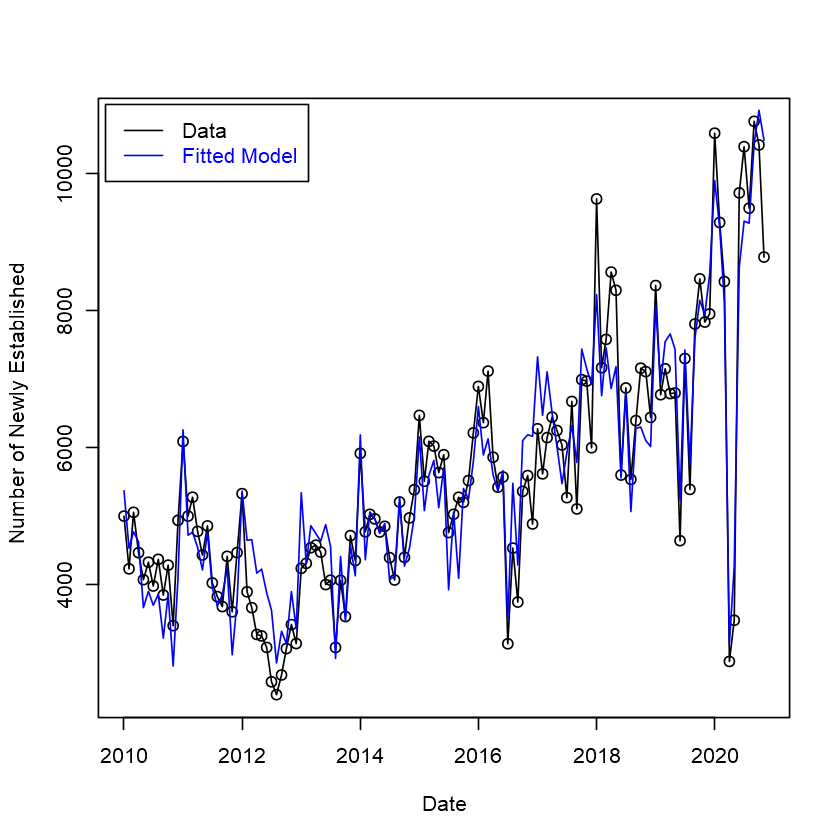


	Breusch-Godfrey test for serial correlation of order up to 22

data:  Residuals
LM test = 53.093, df = 22, p-value = 0.0002204


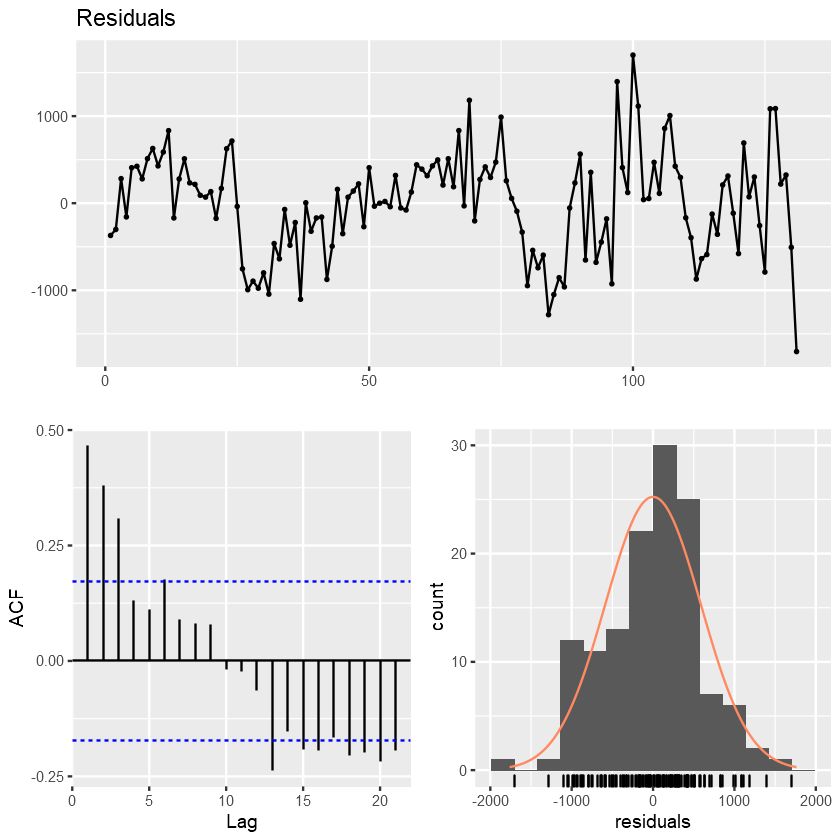

In [6]:
fitModel = lm(formula = NewlyEstablished~Month+Trend+ProdIndex+ExRate+InterestRate+ConfIndex+Survey+UnempRate,data = dtEstablished)

summary(fitModel)

plot(x=dtEstablished$Date, y=dtEstablished[,NewlyEstablished], type = "o", xlab = "Date", ylab = "Number of Newly Established")
lines(x=dtEstablished$Date, y=fitModel$fitted, col = "blue")
legend("topleft", col = c("black", "blue"), text.col = c("black", "blue"), legend = c("Data", "Fitted Model"),
       inset = c(0.01, 0.01), lty = c(1,1))

checkresiduals(fitModel)

# 4. Testing the Model

Below, I have splitted the data as we would have the year 2020's data in test data. I trained the model with the past year's data and tested the accuracy of the model using the test data. The accuracy function is the same with the one we used in the class.

n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
11,8566.727,2769.813,0.01948761,0.1225024,1022.731,870.9273,0.1016639


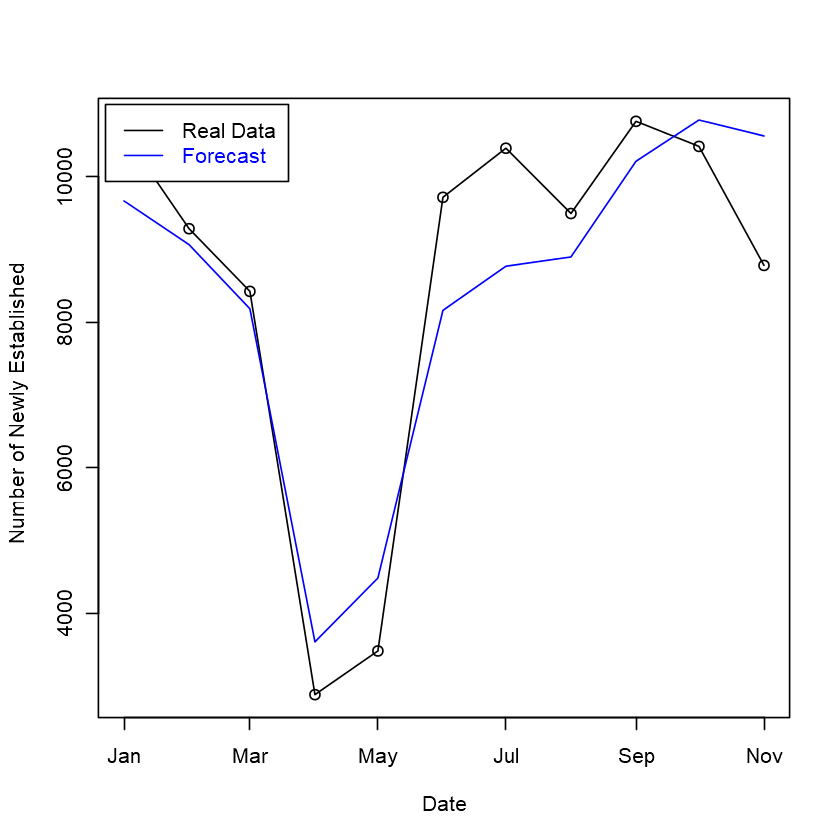

In [7]:
# Splitting Data
testStart = as.Date("2020-01-01")
dtEstablishedTrain = data.table(dtEstablished[Date < testStart])
dtEstablishedTest = data.table(dtEstablished[Date >= testStart])

fitModel = lm(formula = NewlyEstablished~Month+Trend+ProdIndex+ExRate
              +InterestRate+ConfIndex+Survey+UnempRate,data = dtEstablishedTrain)

dtEstablishedTest[, Predicted:=predict(fitModel, dtEstablishedTest)]

# Plotting Real Data vs. Forecasted
plot(x=dtEstablishedTest$Date, y=dtEstablishedTest[,NewlyEstablished],
     type = "o", xlab = "Date", ylab = "Number of Newly Established")
lines(x=dtEstablishedTest$Date, y=dtEstablishedTest[,Predicted], col = "blue")
legend("topleft", col = c("black", "blue"), text.col = c("black", "blue"), legend = c("Real Data", "Forecast"),
       inset = c(0.01, 0.01), lty = c(1,1))

accu = function(actual, forecast){
    n = length(actual)
    error = actual - forecast
    mean = mean(actual)
    sd = sd(actual)
    FBias = sum(error)/sum(actual)
    MAPE = sum(abs(error/actual)) / n
    RMSE = sqrt(sum(error^2) / n)
    MAD = sum(abs(error)) / n
    WMAPE = MAD / mean
    l = data.frame(n, mean, sd, FBias, MAPE, RMSE, MAD, WMAPE)
    return(l)
}

accu(dtEstablishedTest$NewlyEstablished, dtEstablishedTest$Predicted)


The WMAPE value is somewhat high, probably caused by the variations in residuals I wasn't able to assess. However it is not too bad either, the forecasts are pretty close and have similar movement with the data as can be seen on the plot.

# 5. Forecasting December 2020

Here I fit the model again with all the data we have, forecast the December 2020 and plot the last year's data. It looks like the number of newly established firms will be around 9894 which is higher than november's value. The real value of December 2020 is not yet announced, we can see how close the model was and what is the error when it is announced.

Classes 'data.table' and 'data.frame':	1 obs. of  11 variables:
 $ Date            : Date, format: "2020-12-01"
 $ ProdIndex       : num 135
 $ ExRate          : num 7.72
 $ InterestRate    : num 19
 $ ConfIndex       : num 110
 $ Survey          : num 24.5
 $ NewlyEstablished: num NA
 $ UnempRate       : num 12.7
 $ Month           : Factor w/ 12 levels "1","2","3","4",..: 12
 $ Trend           : int 132
 $ Gdp             : num 1.42e+09
 - attr(*, ".internal.selfref")=<externalptr> 


Date,ProdIndex,ExRate,InterestRate,ConfIndex,Survey,NewlyEstablished,UnempRate,Month,Trend,Gdp
2020-12-01,134.7123,7.721065,18.97,110.4,24.5,NA,12.7,12,132,1419482738


Date,ProdIndex,ExRate,InterestRate,ConfIndex,Survey,NewlyEstablished,UnempRate,Month,Trend,Gdp,Predicted
2020-12-01,134.7123,7.721065,18.97,110.4,24.5,NA,12.7,12,132,1419482738,9894.405


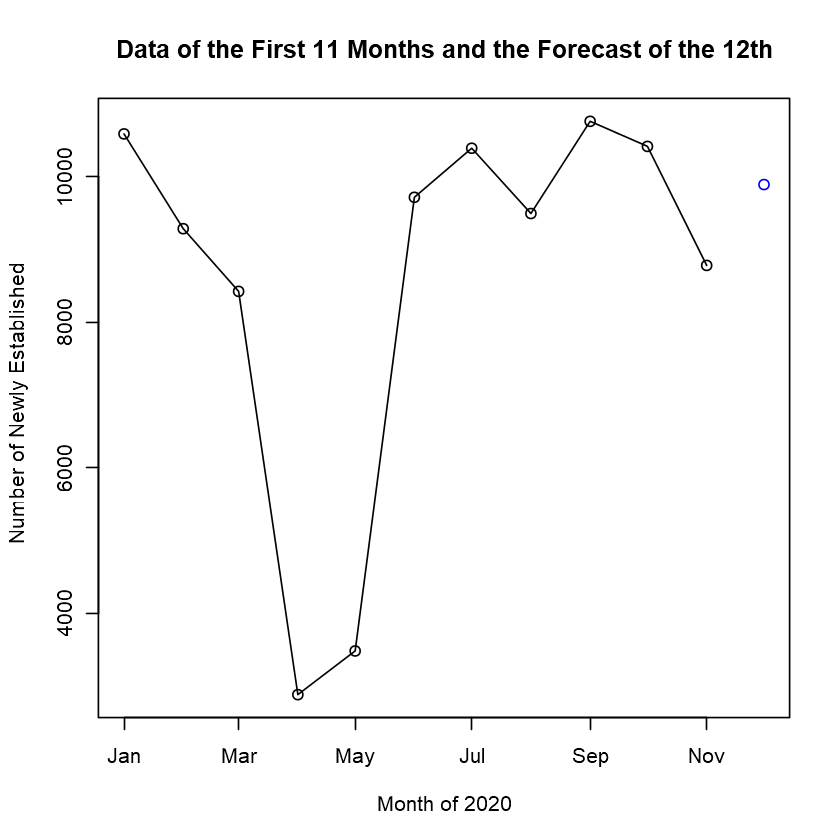

In [8]:
str(goalMonth)

fitModel = lm(formula = NewlyEstablished~Month+Trend+ProdIndex+ExRate+InterestRate+ConfIndex+Survey+UnempRate,data = dtEstablished)

goalMonth
goalMonth[, Predicted:=predict(fitModel, goalMonth)]
goalMonth

plot(xlim = c(as.Date("2020-01-01"), as.Date("2020-12-01")), x = dtEstablished[Date >= "2020-01-01", Date],
     y = dtEstablished[Date >= "2020-01-01", NewlyEstablished], type = "o", xlab = "Month of 2020",
     ylab = "Number of Newly Established", main = "Data of the First 11 Months and the Forecast of the 12th")
points(x = as.Date("2020-12-01"), y = goalMonth$Predicted, col = "blue")

# 6. Conclusion

I have used several macroeconomic factors to build a regression model on the number of newly established firms and used the model to forecast 2020, December. Meanwhile, I made huge assumptions when I filled the missing values using a naive approach. However the results are not too bad. The model was able to closely forecast year 2020 when testing and I hope that the forecast of December 2020 will be close as well.